## Create a Spark Session

In [1]:
import findspark
findspark.init('/afs/cern.ch/work/m/migliori/public/spark-2.4/')

In [2]:
application_name = 'dist-keras-notebook'
master = "local[8]"

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .appName("dist-keras")\
        .config("spark.master", master)\
        .config("spark.driver.memory", "32G")\
        .config("spark.pyspark.python",
                "/afs/cern.ch/work/m/migliori/public/anaconda2/bin/python")\
        .config("spark.local.dir", "/local1/matteo")\
        .config("spark.sql.execution.arrow.enabled", "true")\
        .getOrCreate()

In [4]:
spark

## Load the dataframe

In [5]:
data = spark.read.format("parquet") \
        .load("../more_data.parquet/") 
            
data.count()

58878

In [6]:
data.show(5)

+--------------------+--------------------+-----+
|           hfeatures|           lfeatures|label|
+--------------------+--------------------+-----+
|[125.582424163818...|[[62.019286629953...|    1|
|[453.637893676757...|[[174.23577757887...|    1|
|[137.816619873046...|[[88.344498501277...|    1|
|[404.660964965820...|[[688.94906881130...|    1|
|[0.0,53.927665710...|[[91.383728162291...|    1|
+--------------------+--------------------+-----+
only showing top 5 rows



In [7]:
data.printSchema()

root
 |-- hfeatures: vector (nullable = true)
 |-- lfeatures: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- label: integer (nullable = true)



## Create the images

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import Row
from skimage import draw

%matplotlib notebook

In [9]:
feature_variables = ['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ','ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 
                        #'Charge'
           ]

colors = {'isMu' : 'green',
        'isEle': 'green',
         'isGamma':'blue',
         'isChHad' : 'red',
         'isNeuHad': 'yellow'}

shapes = {'isMu' : 5,
          'isEle': 5,
          'isGamma':3,
          'isChHad' : 4,
          'isNeuHad': 0}

c_colors = [colors[k] for k in feature_variables[13:]]+['black']
cc_colors = [np.asarray(matplotlib.colors.to_rgb(k)) for k in c_colors]
cc_shapes = [shapes[k] for k in feature_variables[13:]]+[0]

print(c_colors)
print(cc_colors)
print(cc_shapes)

['red', 'yellow', 'blue', 'green', 'green', 'black']
[array([1., 0., 0.]), array([1., 1., 0.]), array([0., 0., 1.]), array([0.        , 0.50196078, 0.        ]), array([0.        , 0.50196078, 0.        ]), array([0., 0., 0.])]
[4, 0, 3, 5, 5, 0]


In [10]:
def showImage(image):
    fig = plt.figure(frameon=False)
    plt.imshow(image.swapaxes(0,1))
    plt.axis('off')
    #plt.savefig('fig.png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

def create3D(data):
    max_eta = 5
    max_phi = np.pi
    res= 100
    neta = int(max_eta*res)
    nphi = int(max_phi*res)
    eeta = 2.*max_eta / float(neta)
    ephi = 2.*max_phi / float(nphi)
    def ieta( eta ): return (eta+max_eta) / eeta
    def iphi(phi) : return (phi+max_phi) / ephi
    blend = 0.3
    image = np.ones((neta,nphi,3), dtype = np.float32)
    
    for ip in range(data.shape[0]):
        p_data = data[ip,:]
        eta = p_data[0]
        phi = p_data[1]
        if eta==0 and phi==0: 
            #print ip
            continue
        #pT = p_data[2]
        #lpT = min(max(np.log(pT)/5.,0.001), 10)*res/2.
        lpT = p_data[2]
        ptype = int(p_data[3])
        c = cc_colors[ ptype ]
        s = cc_shapes[ ptype ]
        R = lpT * res/1.5
        iee = ieta(eta)
        ip0 = iphi(phi)
        ip1 = iphi(phi+2*np.pi)
        ip2 = iphi(phi-2*np.pi)
        
        if s==0:
            xi0,yi0 = draw.circle(  iee, ip0,radius=R, shape=image.shape[:2])
            xi1,yi1 = draw.circle( iee, ip1, radius=R, shape=image.shape[:2])
            xi2,yi2 = draw.circle( iee, ip2, radius=R, shape=image.shape[:2]) 
            #if ptype == 5:
            #    print "MET",eta,phi
        else:
            nv = s
            vx = [iee + R*np.cos(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy = [ip0 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy1 = [ip1 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy2 = [ip2 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            xi0,yi0 = draw.polygon( vx, vy , shape=image.shape[:2])
            xi1,yi1 = draw.polygon( vx, vy1 , shape=image.shape[:2])
            xi2,yi2 = draw.polygon( vx, vy2 , shape=image.shape[:2])
            
        xi = np.concatenate((xi0,xi1,xi2))
        yi = np.concatenate((yi0,yi1,yi2))
        image[xi,yi,:] = (image[xi,yi,:] *(1-blend)) + (c*blend)
    return image


def convert2image(row):
    """Assume that a row contains a non-empty 2D matrix of features"""
    lmat = np.asarray(row.lfeatures, dtype=np.float64)
    hmat = np.asarray(row.hfeatures, dtype=np.float64)
    
    label = row.label
    
    # low level features
    l_reduced = np.asarray(np.zeros((lmat.shape[0], 4)))
    l_reduced[:, 0] = lmat[:, 5]
    l_reduced[:, 1] = lmat[:, 6]
    l_reduced[:, 2] = np.minimum(np.log(np.maximum(lmat[:, 4], 1.001))/5., 10)
    l_reduced[:, 3] = np.argmax(lmat[:, 13:], axis=-1)
    
    # high level features
    h_reduced = np.zeros( (1, 4))
    h_reduced[0,2] = np.minimum(np.maximum(np.log(hmat[1])/5.,0.001), 10) # MET
    h_reduced[0,1] = hmat[2] # MET-phi
    h_reduced[0,3] = int(5) ## met type
    
    reduced = np.concatenate((l_reduced, h_reduced), axis=0)
    
    # working: return Row(image=reduced.tolist(), label=label)
    return Row(image=create3D(np.asarray(reduced)).tolist(), label=label)
    # not_working: return Row(image=ImageSchema.toImage(create3D(np.asarray(reduced))), label=label)

In [11]:
images = data.rdd.map(convert2image).toDF()

In [12]:
images.printSchema()

root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |-- label: long (nullable = true)



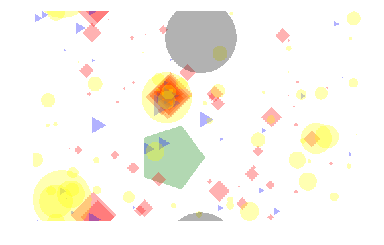

In [13]:
showImage(np.asarray(images.take(1)[0].image))

Save the dataframe as parquet file

In [51]:
%time images.write.parquet('images.parquet', mode='overwrite')

CPU times: user 398 ms, sys: 343 ms, total: 741 ms
Wall time: 1h 52min 51s


## test CNN

In [14]:
from keras.optimizers import *
from keras.models import Sequential
from keras.layers.core import *
from keras.layers.convolutional import *

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *

Using TensorFlow backend.


In [15]:
np.asarray(images.take(1)[0].image).shape

(500, 314, 3)

In [16]:
# Declare model parameters.
img_rows, img_cols, img_channels = 500, 314, 3
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, img_channels)

# Construct the model.
convnet = Sequential()
convnet.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                          border_mode='valid',
                          input_shape=input_shape))
convnet.add(Activation('relu'))
convnet.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
convnet.add(Activation('relu'))
convnet.add(MaxPooling2D(pool_size=pool_size))

convnet.add(Flatten())
convnet.add(Dense(225))
convnet.add(Activation('relu'))
convnet.add(Dense(3))
convnet.add(Activation('softmax'))

/afs/cern.ch/work/m/migliori/public/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(500, 314,...)`
  from ipykernel import kernelapp as app
/afs/cern.ch/work/m/migliori/public/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`


In [17]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 312, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 498, 312, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 496, 310, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 496, 310, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 248, 155, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1230080)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 225)               276768225 
__________

In [18]:
optimizer_convnet = 'adam'
loss_convnet = 'categorical_crossentropy'

In [21]:
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml import Pipeline

encoder = OneHotEncoderEstimator(inputCols=["label"],
                                 outputCols=["encoded_label"],
                                 dropLast=False)

pipeline = Pipeline(stages=[encoder])
fitted_pipeline = pipeline.fit(images)

In [23]:
train = fitted_pipeline.transform(images)

In [24]:
train.show(5)

+--------------------+-----+-------------+
|               image|label|encoded_label|
+--------------------+-----+-------------+
|[[[1.0, 1.0, 1.0]...|    1|(3,[1],[1.0])|
|[[[1.0, 1.0, 1.0]...|    1|(3,[1],[1.0])|
|[[[1.0, 1.0, 1.0]...|    1|(3,[1],[1.0])|
|[[[0.699999988079...|    1|(3,[1],[1.0])|
|[[[1.0, 1.0, 1.0]...|    1|(3,[1],[1.0])|
+--------------------+-----+-------------+
only showing top 5 rows



In [27]:
trainer = AEASGD(keras_model=convnet, worker_optimizer=optimizer_convnet, loss=loss_convnet, 
                 num_workers=5, batch_size=32, communication_window=32, num_epoch=1,
                 features_col="image", label_col="encoded_label")
%time trained_model = trainer.train(train)

CPU times: user 32.5 s, sys: 26.5 s, total: 59 s
Wall time: 1min 38s


In [30]:
test = train.take(1)[0].image

In [36]:
predictor = ModelPredictor(keras_model=trained_model, features_col='image')
pred = predictor.predict(train.limit(5))

In [37]:
pred.show(5)

+--------------------+-----+-------------+--------------------+
|               image|label|encoded_label|          prediction|
+--------------------+-----+-------------+--------------------+
|[[[1.0, 1.0, 1.0]...|    1|(3,[1],[1.0])|[0.40516602993011...|
|[[[1.0, 1.0, 1.0]...|    1|(3,[1],[1.0])|[0.38794946670532...|
|[[[1.0, 1.0, 1.0]...|    1|(3,[1],[1.0])|[0.38265267014503...|
|[[[0.699999988079...|    1|(3,[1],[1.0])|[0.38981512188911...|
|[[[1.0, 1.0, 1.0]...|    1|(3,[1],[1.0])|[0.39766237139701...|
+--------------------+-----+-------------+--------------------+



In [38]:
pred.take(1)[0].prediction

DenseVector([0.4052, 0.3576, 0.2373])

Densenet

In [41]:
from densenet import DenseNet

In [42]:
model = DenseNet(nb_classes = 3, img_dim = (500, 314, 3), depth = 10, 
                 nb_dense_block = 2, growth_rate = 3, 
                 dropout_rate= 0.5, nb_filter = 12)

tf
tf


In [43]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500, 314, 3)  0                                            
__________________________________________________________________________________________________
initial_conv2D (Conv2D)         (None, 12, 314, 3)   54000       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 12, 314, 3)   48          initial_conv2D[0][0]             
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 12, 314, 3)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

In [45]:
#train, test = train.randomSplit([0.8, 0.2])
train.printSchema()

root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |-- label: long (nullable = true)
 |-- encoded_label: vector (nullable = true)



In [46]:
trainer_densenet = AEASGD(keras_model=model, worker_optimizer=optimizer_convnet, loss=loss_convnet, 
                 num_workers=6, batch_size=32, communication_window=32, num_epoch=1,
                 features_col="image", label_col="encoded_label")
%time trained_model_densenet = trainer_densenet.train(train)

CPU times: user 39min 47s, sys: 41min 45s, total: 1h 21min 32s
Wall time: 43min 15s


In [47]:
predictor = ModelPredictor(keras_model=trained_model_densenet, features_col='image')
pred = predictor.predict(train.limit(2))

In [48]:
pred.show()

+--------------------+-----+-------------+--------------------+
|               image|label|encoded_label|          prediction|
+--------------------+-----+-------------+--------------------+
|[[[0.699999988079...|    1|(3,[1],[1.0])|[0.38277775049209...|
|[[[0.699999988079...|    1|(3,[1],[1.0])|[0.38393911719322...|
+--------------------+-----+-------------+--------------------+



## Tests with ImageSchema

In [14]:
from pyspark.ml.image import ImageSchema

In [15]:
img_test = np.asarray(images.take(1)[0].image)

In [16]:
img_test.shape

(500, 314, 3)

In [17]:
img_test[:10]

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

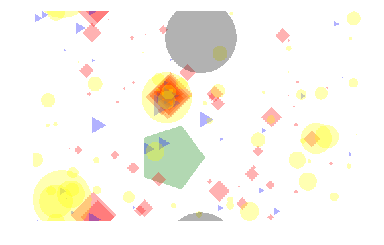

In [18]:
showImage(img_test)

In [19]:
## Encode the image
img_schema_test = ImageSchema.toImage(img_test)

In [20]:
print(img_schema_test.height)
print(img_schema_test.width)

500
314


In [21]:
img_schema_test.data[:10]

bytearray(b'\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01')

In [22]:
img_converted = ImageSchema.toNDArray(img_schema_test)
img_converted.shape

(500, 314, 3)

In [23]:
img_converted[:10]

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

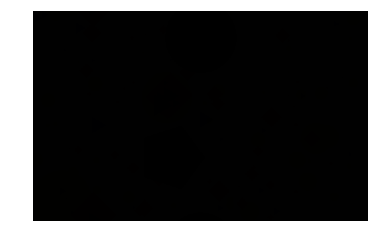

In [24]:
showImage(ImageSchema.toNDArray(img_schema_test))